# Bayesian analysis of the empirical saturation point (refactored version)

In [1]:
from modules.SaturationAnalysis import SaturationAnalysis

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Performing Bayesian linear regression on EFT predictions


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]


/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 19 seconds.


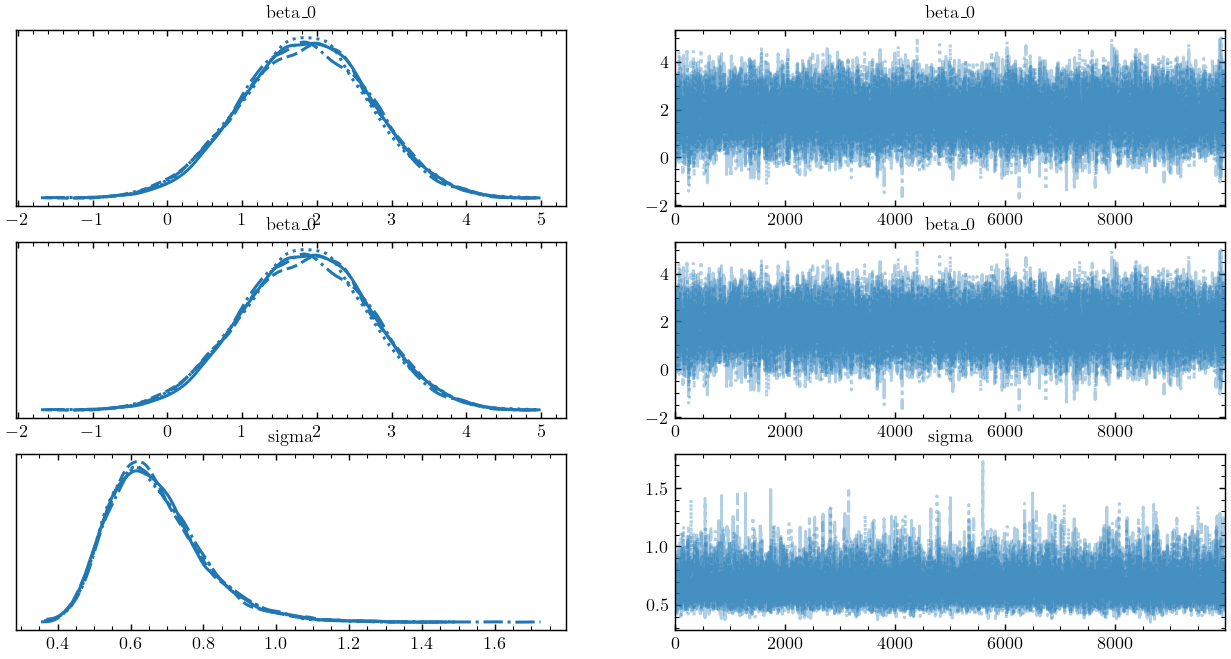

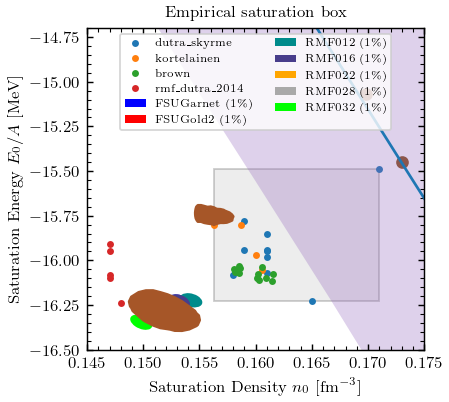

In [3]:
analysis = SaturationAnalysis()
analysis.plot_contraints(eft=True, eft_conf_level=0.95)

In [4]:
from modules.DataSets import DataSetSampleConfig, Scenario
from modules.SaturationAnalysis import DEFAULT_DFT_CONSTRAINTS as dft_constraints
scenario1 = Scenario(label="FSU-only",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["FSU"])])
scenario2 = Scenario(label="FSU+Schunck-only",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["FSU"]),
                              DataSetSampleConfig(data_set=dft_constraints["Schunck"])])
scenario3 = Scenario(label="all",
                     configs=[DataSetSampleConfig(data_set=dft_constraints[lbl]) for lbl in dft_constraints.keys()])
scenario4 = Scenario(label="Giuliani+Schunck-only",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["Giuliani"]),
                              DataSetSampleConfig(data_set=dft_constraints["Schunck"])])

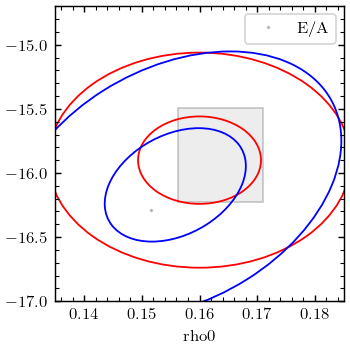

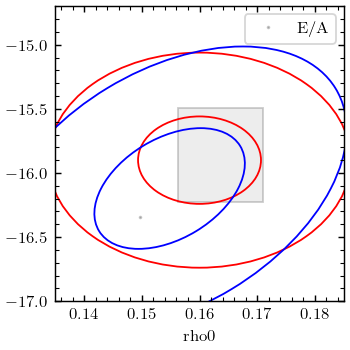

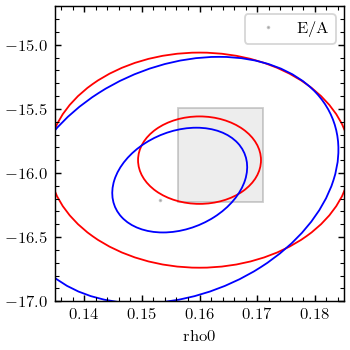

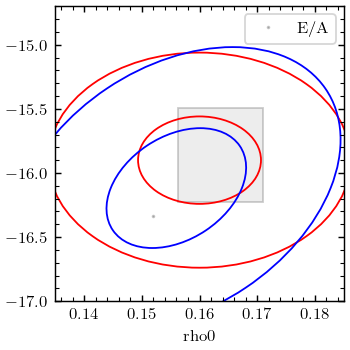

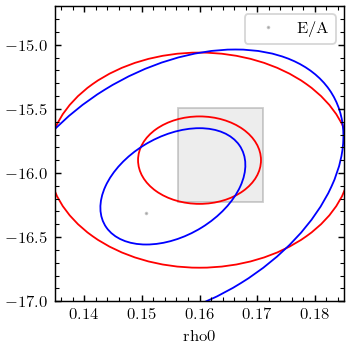

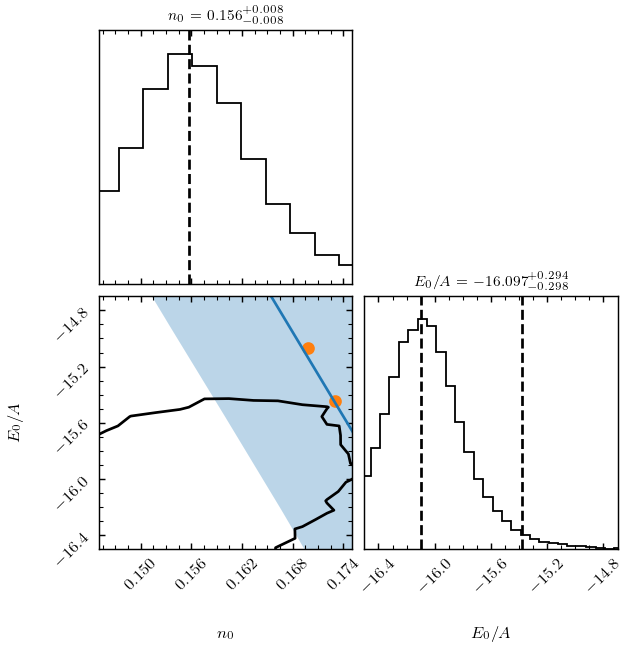

In [5]:
analysis.multiverse(scenario1)

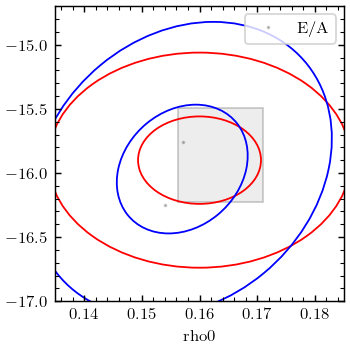

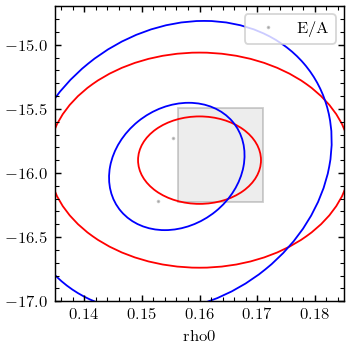

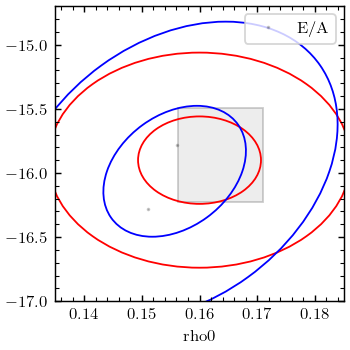

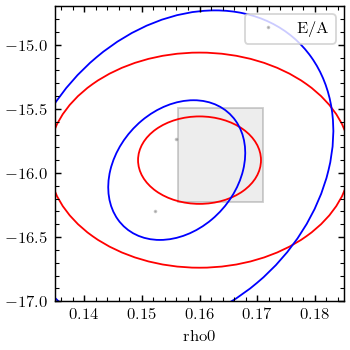

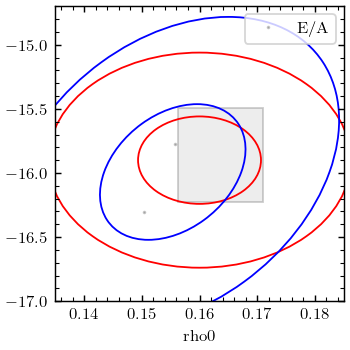

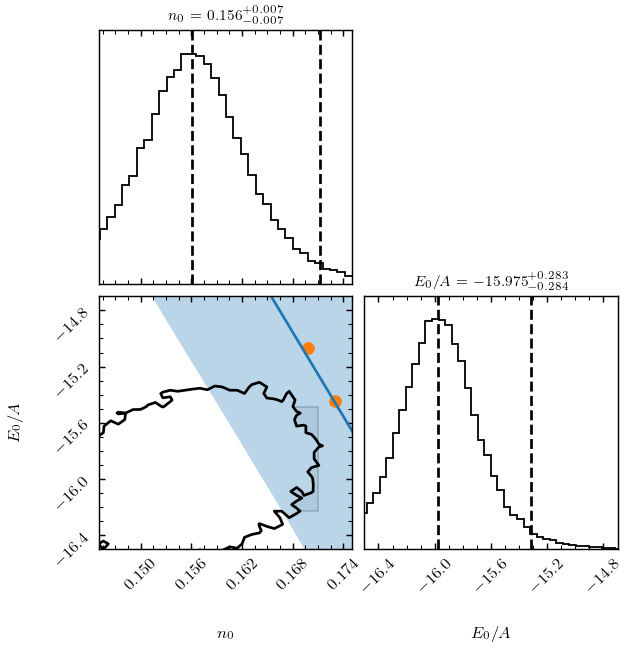

In [6]:
analysis.multiverse(scenario2)

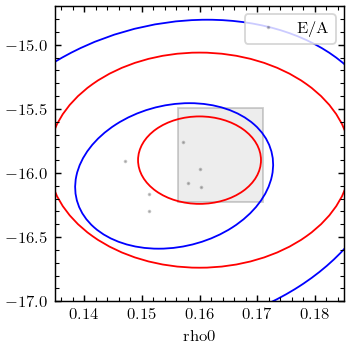

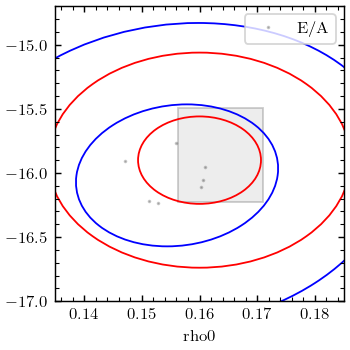

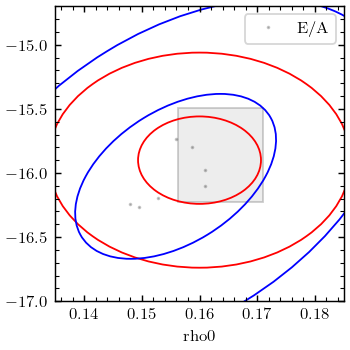

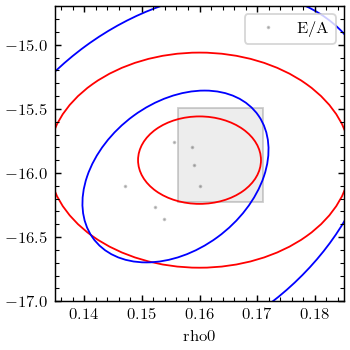

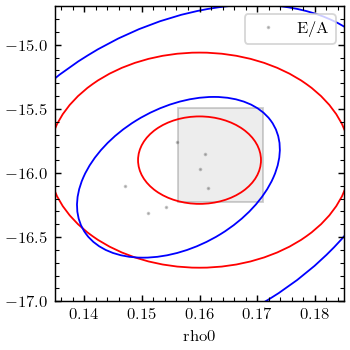

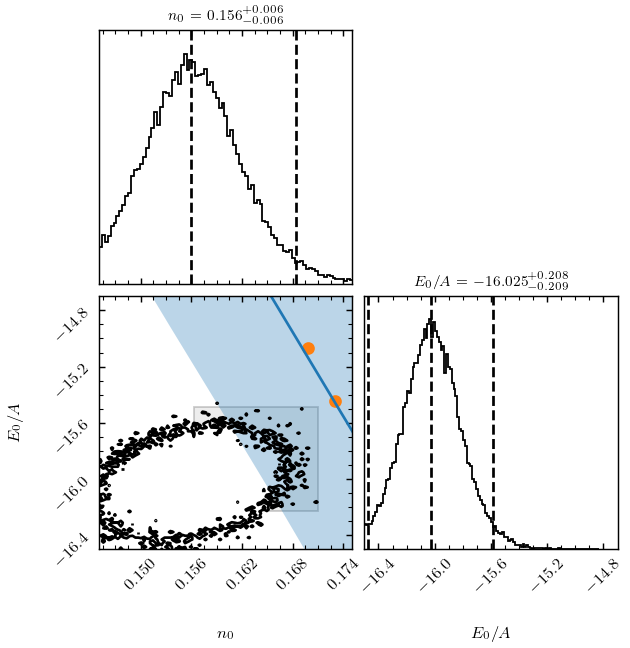

In [7]:
analysis.multiverse(scenario3)

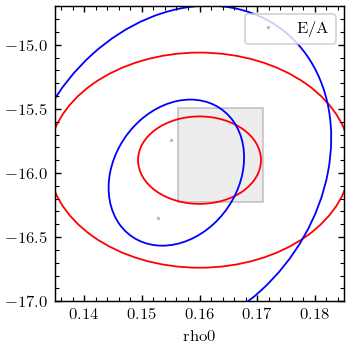

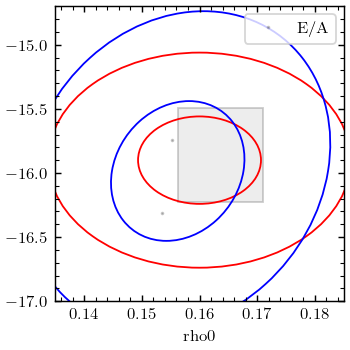

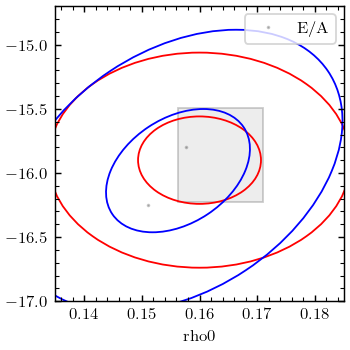

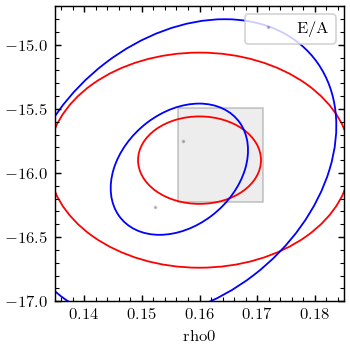

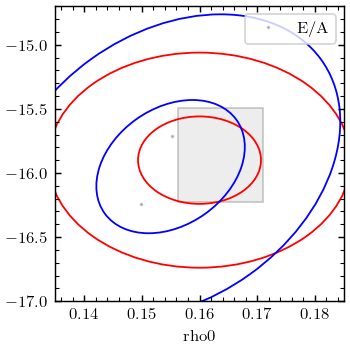

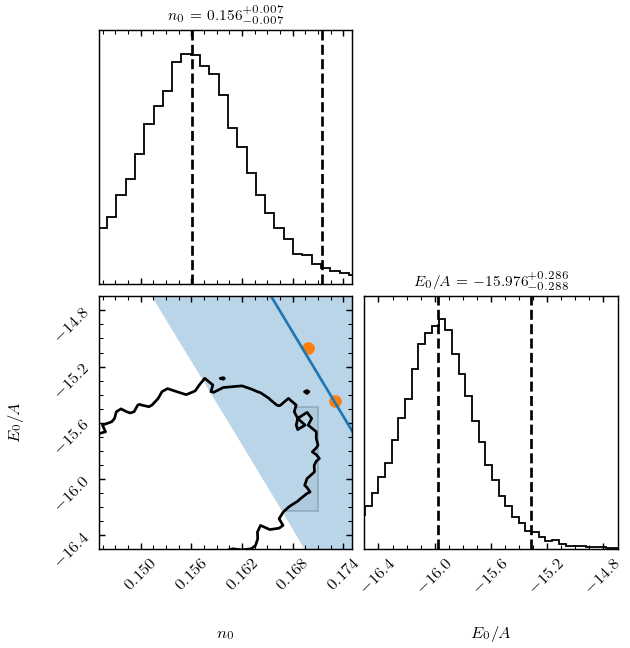

In [8]:
analysis.multiverse(scenario4)

Iterating over DFT constraints: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:11<00:00,  1.57s/it]


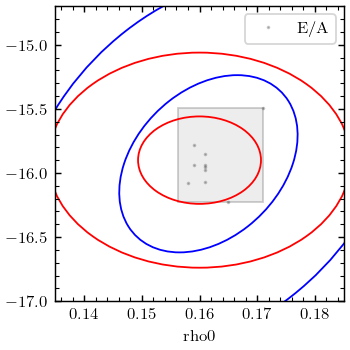

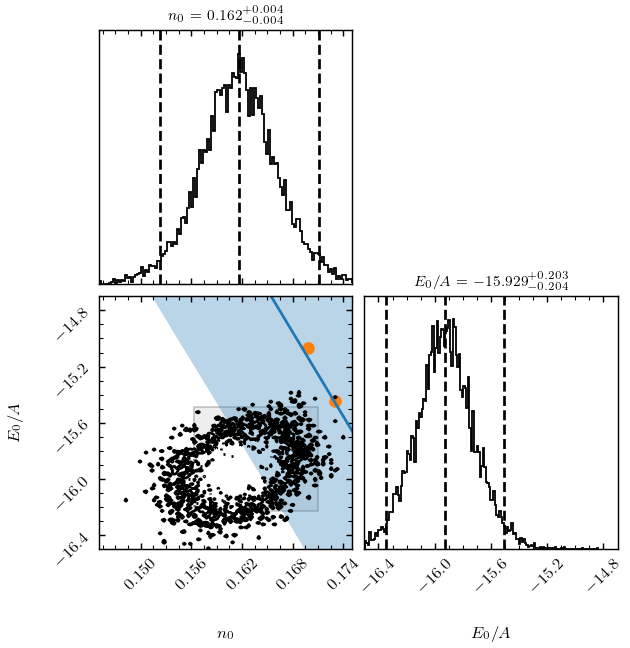

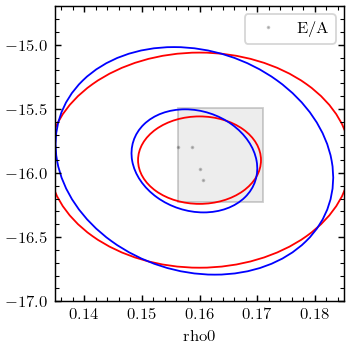

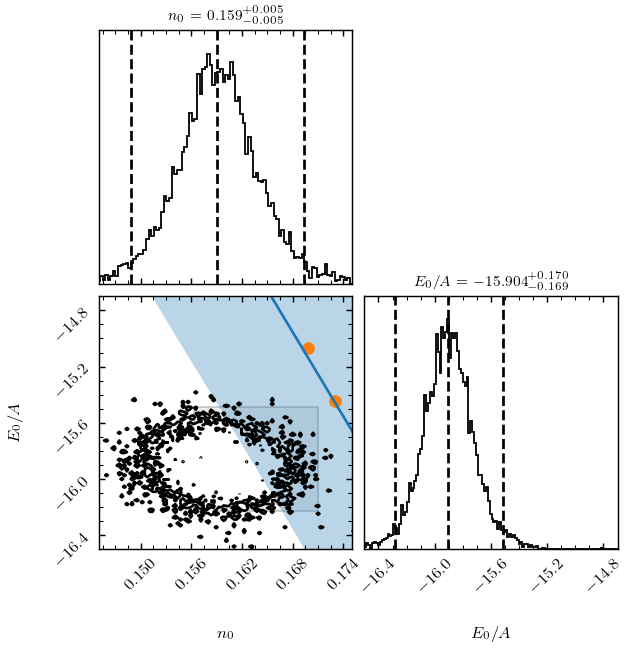

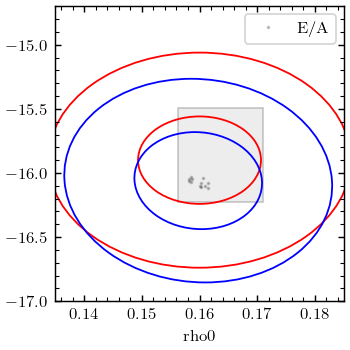

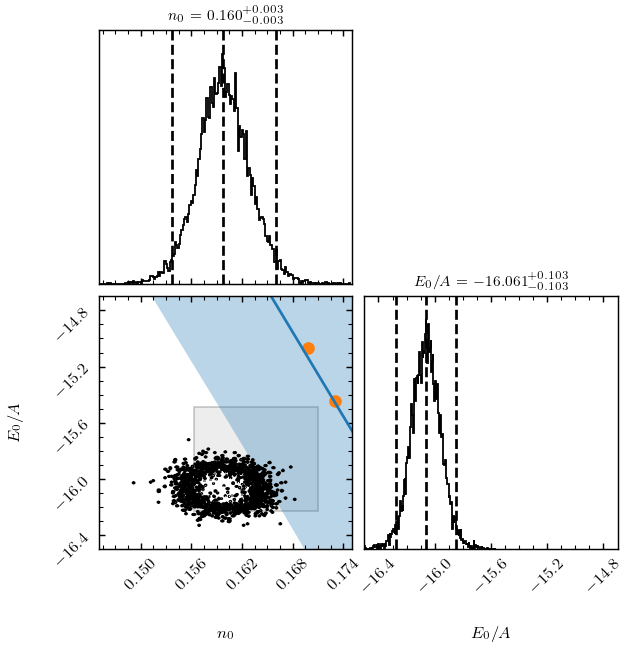

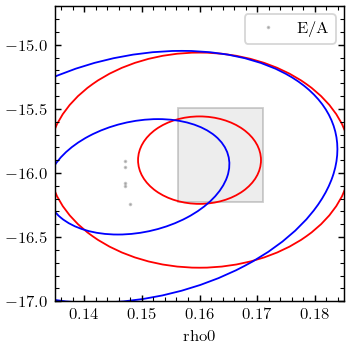

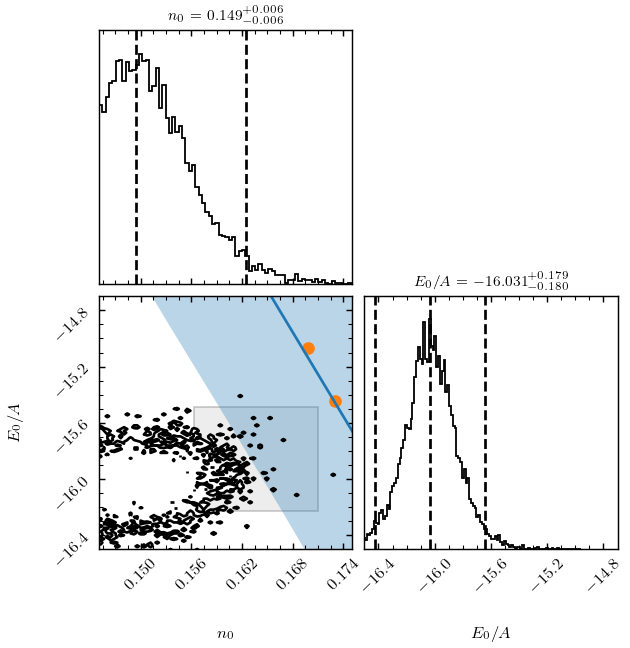

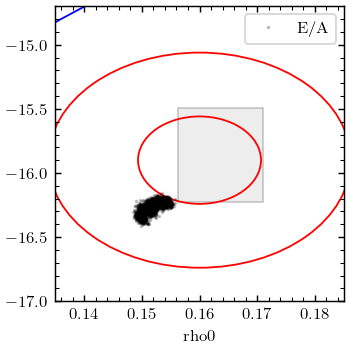

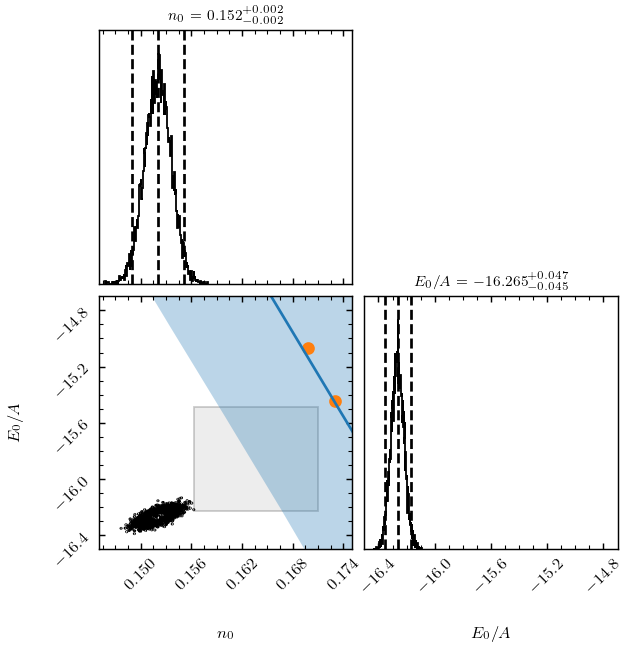

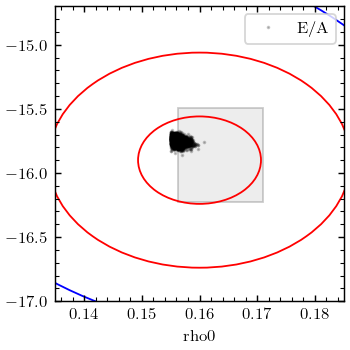

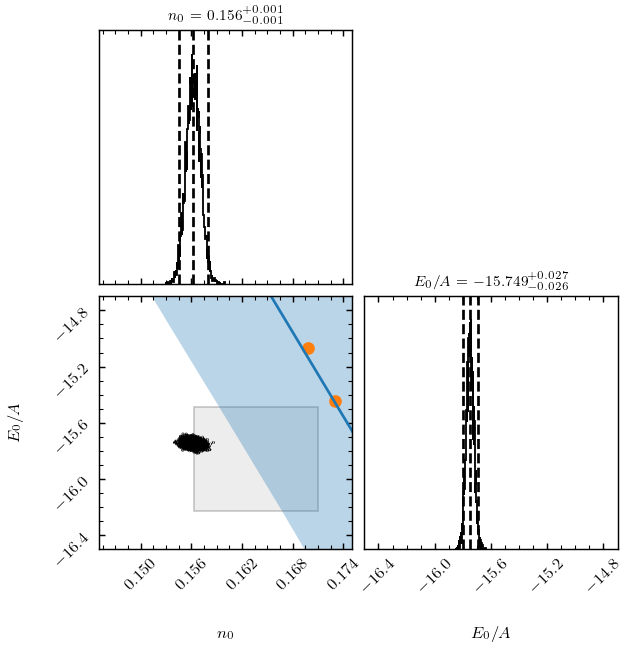

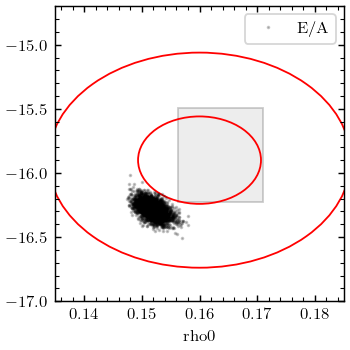

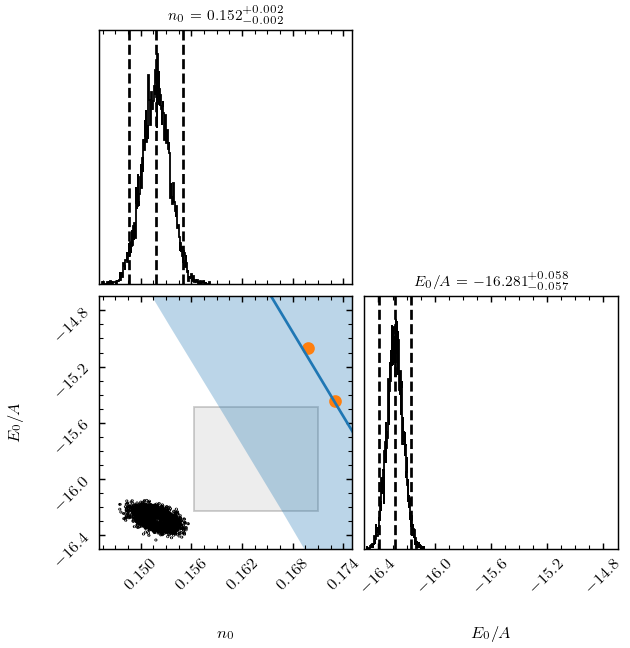

In [9]:
analysis.plot_individual_models()